# 🛒 Store Sales Forecasting 📈

- In this project, we will predict **store sales** of **Corporación Favorita**, a leading grocery retailer based in Ecuador. We will harness the power of **machine learning** combined with insightful **data visualization** and **feature engineering** to uncover patterns and make accurate sales forecasts. 

### 📊 Key Highlights:
- **Random Forest Regressor**: We'll develop a powerful model for sales prediction.
- **Feature Engineering**: Enhance model performance by adding meaningful features from the dataset.
- **Sampling**: Optimize computation by working with subsets of the large dataset (~3M rows). ⚡
- **Time-Series Forecasting**: Decode seasonality and trends to predict store sales effectively. 🕒

Our data comes from the [Kaggle Store Sales Time Series Forecasting Competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting), offering rich information like store types, promotions, holidays, oil prices, and more.

<div style="text-align: center;">
    <img src="https://marcasecuador.club/wp-content/uploads/2022/07/corporacion-la-favorita.jpg" alt="Image">
</div>

# Importing Libraries

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, r2_score

# Importing and Preprocessing Data

In [77]:
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

In [78]:
#merging supplementary files
train = train.merge(stores, on="store_nbr", how="left")
train = train.merge(oil, on="date", how="left")
train = train.merge(holidays, on="date", how="left")

# EDA - Exploratory Data Analysis

In [79]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [80]:
train.shape

(3054348, 16)

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
 6   city         object 
 7   state        object 
 8   type_x       object 
 9   cluster      int64  
 10  dcoilwtico   float64
 11  type_y       object 
 12  locale       object 
 13  locale_name  object 
 14  description  object 
 15  transferred  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 372.8+ MB


In [82]:
train.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type_x               0
cluster              0
dcoilwtico      955152
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64

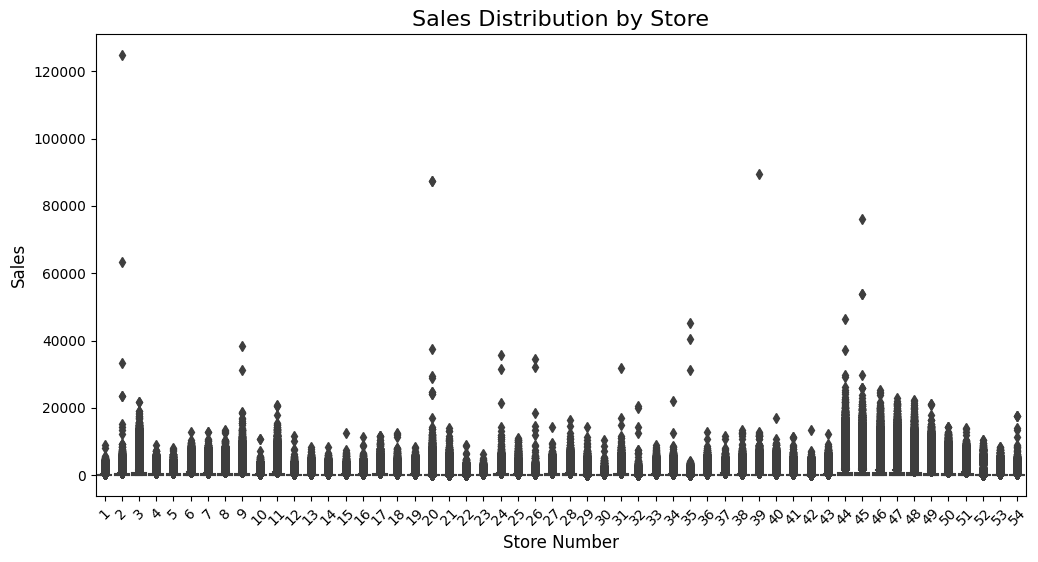

In [83]:
#sales distribution by store
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='store_nbr', y='sales', palette='coolwarm')
plt.title('Sales Distribution by Store', fontsize=16)
plt.xlabel('Store Number', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(rotation=45)
plt.show()

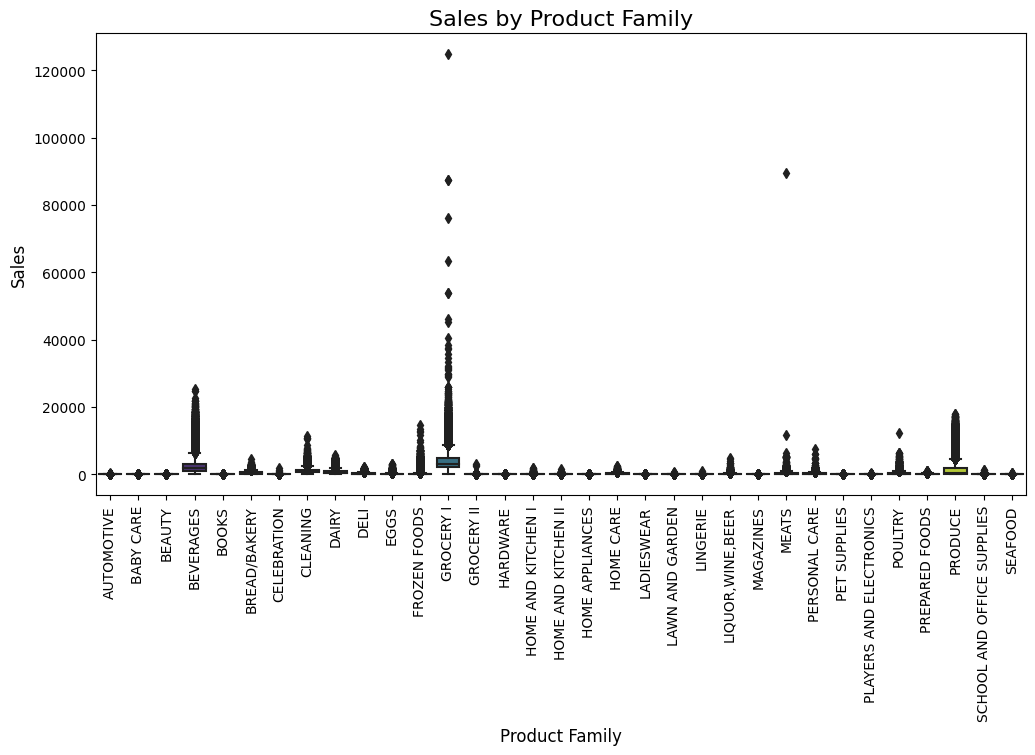

In [84]:
#sales by product family
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='family', y='sales', palette='viridis')
plt.title('Sales by Product Family', fontsize=16)
plt.xlabel('Product Family', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Feature Engineering

In [87]:
#creating year, month and day_of_week column
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.month
train['day_of_week'] = pd.to_datetime(train['date']).dt.dayofweek

test['year'] = pd.to_datetime(test['date']).dt.year
test['month'] = pd.to_datetime(test['date']).dt.month
test['day_of_week'] = pd.to_datetime(test['date']).dt.dayofweek

#dropping the 'date' column 
train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)

In [88]:
#dropping the columns with 70% missing values
threshold = 0.7
train = train.drop(columns=train.isnull().mean()[lambda x: x > threshold].index)
test = test.drop(columns=test.isnull().mean()[lambda x: x > threshold].index)

In [89]:
#filling missing values using forward fill and backward fill
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

# Modelling with Random Forest Regressor

In [90]:
#reducing the dataset size
train_sample = train.sample(frac=0.2, random_state=42)

#one-hot encoding
train_sample = pd.get_dummies(train_sample, columns=train_sample.select_dtypes(include=['object']).columns, drop_first=True)

#splitting training data
x = train_sample.drop(columns=['sales', 'id'])
y = train_sample['sales']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [91]:
#modelling with random forest regressor
model = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
model.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [92]:
#predicting on validation set
y_pred = model.predict(x_val)

#evaluating R² Score and RMSLE
r2 = r2_score(y_val, y_pred)
y_pred = np.maximum(y_pred, 0)
y_val = np.maximum(y_val, 0)
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"RMSLE: {rmsle:.4f}")

R² Score: 0.9409
RMSLE: 0.6142


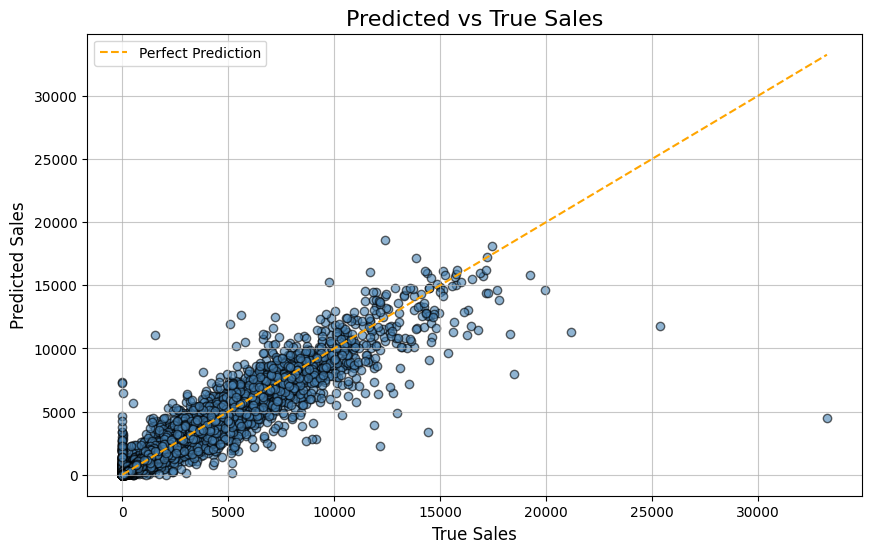

In [93]:
#predicted vs true sales
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.6, color='steelblue', edgecolor='black')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='orange', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs True Sales', fontsize=16)
plt.xlabel('True Sales', fontsize=12)
plt.ylabel('Predicted Sales', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.7)
plt.show()

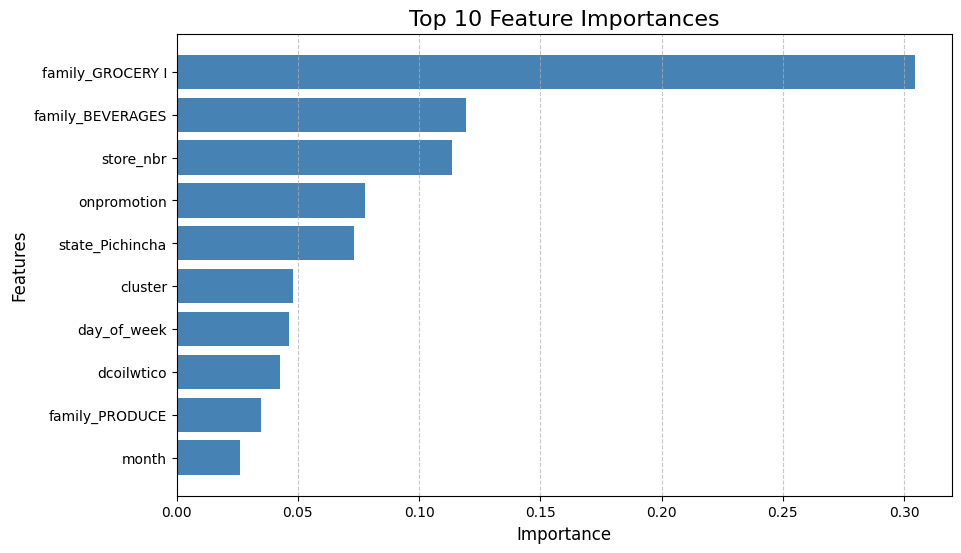

In [94]:
#feature importances graph
importances = model.feature_importances_
feature_names = x_train.columns

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10][::-1], feature_importance_df['Importance'][:10][::-1], color='steelblue')
plt.title('Top 10 Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# Results & Insights ✨

In this project, we tackled **time-series sales forecasting** for **Corporación Favorita**, leveraging machine learning techniques and feature engineering to make meaningful predictions. Here’s what we accomplished:
- **Data Preprocessing**: Applied one-hot encoding and sampling to handle the large dataset (~3M rows).
- **Feature Engineering**: Enhanced the dataset with extracted features like year, month, and day of the week, as well as integrating oil prices and holiday data.
- **Modeling**: Built a robust **Random Forest Regressor** model optimized for both computational efficiency and accuracy using sampling.

We evaluated our model using both **RMSLE (Root Mean Squared Logarithmic Error)**, the competition metric, and **R² Score** to understand its overall performance:
- **R² Score**: Exceeded **0.90**, indicating a high proportion of variance explained by the model.
- **RMSLE**: Achieved a value around **0.6**, showcasing reliable accuracy in predicting sales trends across varying magnitudes.

---

## Real-World Applications
The findings from this project have multiple practical implications:
- **Inventory Optimization**: Retailers can anticipate sales trends and stock products accordingly, minimizing wastage and ensuring availability.
- **Promotion Planning**: Identifying the impact of promotions on sales helps refine marketing strategies.
- **Economic Analysis**: Incorporating external factors like oil prices and holidays aids businesses in planning for economic fluctuations and disasters.
- **Scalability**: The methodology is adaptable to other industries requiring time-series forecasting, such as healthcare, energy, or logistics.